### **PINN eikonal solver for an elliptically anisotropic model with topography**

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_isotropic_eikonal_R1"

In [ ]:
!pip install sciann
!pip install tensorflow==2.2.0
#!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel
from sciann.utils import *
from scipy.ndimage import gaussian_filter1d
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [5]:
np.random.seed(123)
tf.random.set_seed(123)

In [6]:
# Loading velocity models

velz = np.load("./inputs/vtiseam/model/vz.npy")
vz = velz[::50,::50]

velx = np.load("./inputs/vtiseam/model/vx.npy")
vx = velx[::50,::50]

epsilon = 0.5*(vx**2/vz**2 - 1)
eta = epsilon*0.

In [7]:
#Model specifications

# Grid on the vertical(z) and horizontal(y) axes
zmin = 0.
zmax = 10.
deltaz = 0.05
xmin = 0.
xmax = 10.
deltax = 0.05

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

# Source location on the vertical (sz) and horizontal(sy) axes

sz=8.0
sx=5.0
print('Source location:(%.2f,%.2f)'%(sx,sz))

num_tr_pts = 5000

Source location:(5.00,8.00)


In [9]:
# Creating topography
topo = np.loadtxt('./inputs/vtiseam/model/elevation.txt')[0:401:2,2]/1000;
topo = gaussian_filter1d(topo, 8)
topo = 100*np.gradient(np.gradient(topo))+np.round(1.2 + 1.2*np.sin(x)*np.cos(x) ,4)

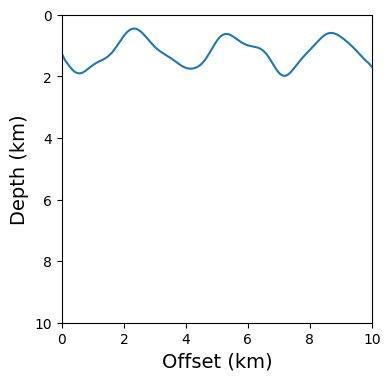

In [10]:
# Plot the topography layer

plt.style.use('default')

plt.figure(figsize=(4,4))
plt.plot(x,topo)
plt.xlim(xmin,xmax)
plt.ylim(zmin,zmax)
plt.gca().invert_yaxis()
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.show()

In [11]:
# Creating grid with points above topography markes as NaN

Z = []
X = []

# For each x component, the loop marks y values above topo at that x to be Nan
for i in enumerate(x):

  index = i[0]; xval = i[1]
  ztemp = [z[j[0]] if z[j[0]] >= topo[index] else float("Nan") for j in enumerate(z)]       
  Z = np.append(Z, ztemp)
  X = np.append(X,np.ones(len(ztemp))*xval)

# Copying Nan from Z to X
X = X + Z*0.

# Reshaping X and Z to the original model size
X = X.reshape(np.meshgrid(z,x,indexing='ij')[0].shape).T
Z = Z.reshape(np.meshgrid(z,x,indexing='ij')[0].shape).T
TOPO = np.divide(X, X, out=np.ones_like(X), where=X!=0)

In [12]:
X_star = [Z.reshape(-1,1), X.reshape(-1,1)] # Grid points for prediction 


# Total training point include the number of training points above plus the ratio of Nans in the original X
tot_tr_pts = int(round(num_tr_pts*(np.sum(1+np.isnan(X))/X.size)))

# Select total training points (this would be slightly different than num_tr_pts)
selected_pts = np.random.choice(np.arange(Z.size),tot_tr_pts,replace=False)

selected_pts = X.reshape(-1,1)[selected_pts]*0 + selected_pts.reshape(-1,1)
selected_pts = selected_pts[~np.isnan(selected_pts)]
selected_pts = selected_pts.astype(int)


Zf = Z.reshape(-1,1)[selected_pts]
Zf = np.append(Zf,sz)
Xf = X.reshape(-1,1)[selected_pts]
Xf = np.append(Xf,sx)


X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)] # Grid points for training

In [13]:
# Checking if any NaN value is left unremoved in selected points for training
np.sum(np.isnan(X_starf))

0

In [14]:
# Overlaying topography on the model

vz = vz*TOPO
vx = vx*TOPO
epsilon = epsilon*TOPO
eta = eta*TOPO

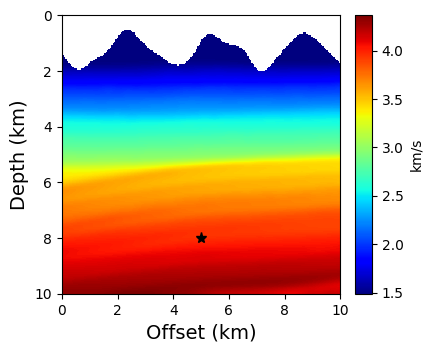

In [15]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(vz, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vtiseam/vz.pdf", format='pdf', bbox_inches="tight")

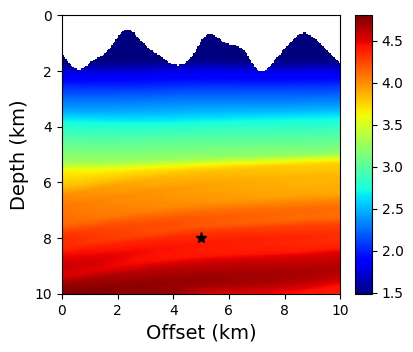

In [16]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(vx, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

#cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vtiseam/vx.pdf", format='pdf', bbox_inches="tight")

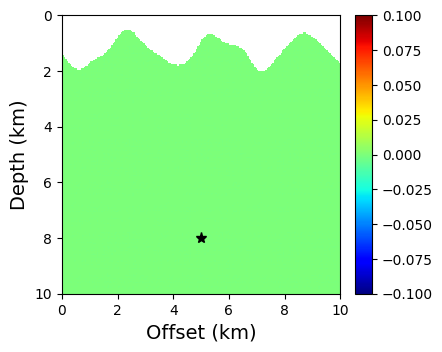

In [18]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(eta, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

#cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/vtiseam/eta.pdf", format='pdf', bbox_inches="tight")

In [19]:
# Analytical solution for the known traveltime part

vx0 = vx[int(round(sz/deltaz)),int(round(sx/deltax))]
vz0 = vz[int(round(sz/deltaz)),int(round(sx/deltax))]

T0 = np.sqrt(((vz0**2)*(X-sx)**2 + (vx0**2)*(Z-sz)**2 )/(vx0**2*vz0**2)); 

px0 = np.divide(X-sx, (vx0**2)*T0, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, (vz0**2)*T0, out=np.zeros_like(T0), where=T0!=0)

In [20]:
# Find source location id in X_starf

TOLX = 1e-6
TOLZ = 1e-6

sids,_ = np.where(np.logical_and(np.abs(X_starf[0]-sz)<TOLZ , np.abs(X_starf[1]-sx)<TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids,0])
print(X_starf[1][sids,0])

[4954]
(1,)
[8.]
[5.]


In [21]:
# Preparing the Sciann model object

K.clear_session() 

layers = [20]*10 

# Appending source values
vzf = vz.reshape(-1,1)[selected_pts]; vzf = np.append(vzf,vz[int(round(sz/deltaz)),int(round(sx/deltax))])
epsilonf = epsilon.reshape(-1,1)[selected_pts]; epsilonf = np.append(epsilonf,epsilon[int(round(sz/deltaz)),int(round(sx/deltax))])
etaf = eta.reshape(-1,1)[selected_pts]; etaf = np.append(etaf,eta[int(round(sz/deltaz)),int(round(sx/deltax))])
px0f = px0.reshape(-1,1)[selected_pts]; px0f = np.append(px0f,0.)
pz0f = pz0.reshape(-1,1)[selected_pts]; pz0f = np.append(pz0f,0.)
T0f = T0.reshape(-1,1)[selected_pts]; T0f = np.append(T0f,0.)

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
epst = Variable("epst",dtype='float64')
etat = Variable("etat",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')

tau = Functional("tau", [zt, xt], layers, 'l-atan')

dtdx = T0t*diff(tau, xt) + tau*px0t
dtdz = T0t*diff(tau, zt) + tau*pz0t

cnst = (2*etat*(vt**2)*(1+2*epst))/(1+2*etat)

L = (1+2*epst)*dtdx**2 + (dtdz**2)*(1-cnst*dtdx**2) - 1/vt**2


targets = [tau, 20*L, (1-sign(tau*T0t))*abs(tau*T0t)]
target_vals = [(sids, np.ones(sids.shape).reshape(-1,1)), 'zeros', 'zeros']

model = SciModel(
    [zt, xt, vt, epst, etat, pz0t, px0t, T0t], 
    targets,
    load_weights_from='models/vofz_model-end.hdf5',
    optimizer='scipy-l-BFGS-B'
)

In [ ]:
#Model training

start_time = time.time()
hist = model.train(
       X_starf + [vzf,epsilonf, etaf, pz0f, px0f, T0f],
       target_vals,
       batch_size = X_starf[0].size,
       epochs = 2000,
       learning_rate = 0.01,
       verbose=0
       )
elapsed = time.time() - start_time
print('Training time: %.2f s' %(elapsed))


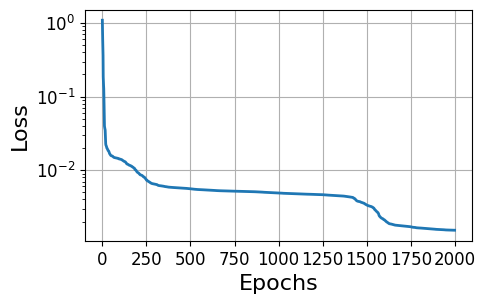

In [23]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'],LineWidth=2)

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)
#ax.xaxis.set_major_locator(plt.MultipleLocator(40000))

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12);
plt.grid()

In [24]:
# Predicting traveltime solution from the trained model

L_pred = L.eval(model, X_star + [vz,epsilon, eta, pz0,px0,T0])
tau_pred = tau.eval(model, X_star + [vz,epsilon, eta, pz0,px0,T0])
tau_pred = tau_pred.reshape(Z.shape)

Tpred = tau_pred*T0

print('Time at source: %.4f'%(tau_pred[int(round(sz/deltaz)),int(round(sx/deltax))]))

Time at source: 0.9993


In [25]:
# Load fast sweeping traveltims for comparison

Tref = np.load('./inputs/vtiseam/traveltimes/Tref.npy')*TOPO
Tcomp = np.load('./inputs/vtiseam/traveltimes/Tcomp.npy')*TOPO

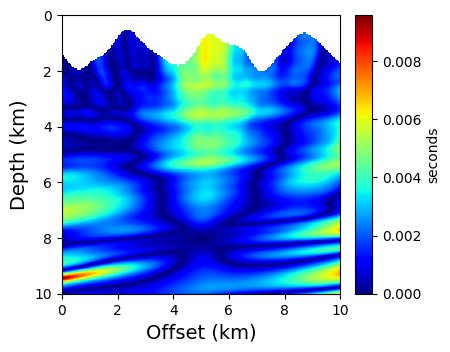

In [ ]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(Tpred-Tref), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vtiseam/pinnerror.pdf", format='pdf', bbox_inches="tight")

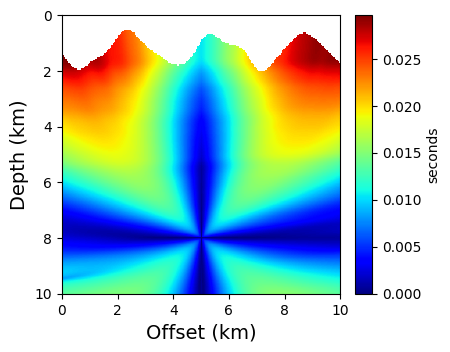

In [26]:
# Plot the FSM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(Tref-Tcomp), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vtiseam/fsmerror.pdf", format='pdf', bbox_inches="tight")

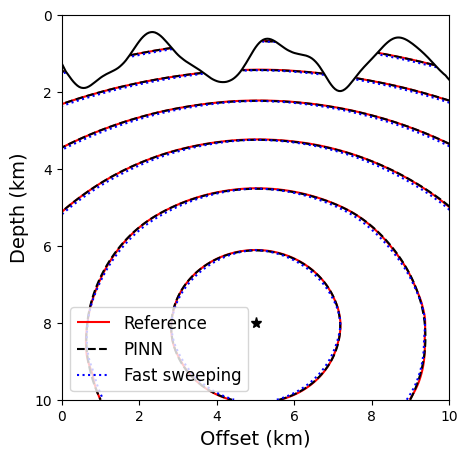

In [ ]:
# Traveltime contour plots

fig = plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(Tref, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(Tpred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(Tcomp, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')
plt.plot(x,topo,'k')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Reference', 'PINN', 'Fast sweeping'],fontsize=12,loc='lower left')

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#ax.arrow(9.5, 2., -0.5, -0.3, head_width=0.3, head_length=0.12, fc='red', ec='red',width=0.1)

#ax.arrow(0.3, 3., 0.6, -0.1, head_width=0.3, head_length=0.12, fc='red', ec='red',width=0.1)

plt.savefig("./figs/vtiseam/contours.pdf", format='pdf', bbox_inches="tight")

In [ ]:
!nvidia-smi


Tue Feb 23 11:19:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------